In [1]:
import os
import cv2
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
def scale_ycrcb(img_ycrcb):
    """
    Retorna una imagen escalada en (-128,128)
    """
    tem = np.zeros(img_ycrcb.shape, dtype=int)
    tem[:,:,0] = img_ycrcb[:,:,0]
    tem[:,:,1] = img_ycrcb[:,:,1] + (-128)
    tem[:,:,2] = img_ycrcb[:,:,2] + (-128)
    return tem

In [3]:
def arrowsimg(array_dydx, defacing = 0):
    """
    image_dydx: dydx Channels of an image (2D)
    defacing: If the reference map is defacing with respect to the YCrCb map
    return: magnitudes and angles of the arrows
    """
    #___________________________________________________________________________
    assert(array_dydx.ndim == 3), "The array is not 3D array"
    assert(array_dydx.shape[2] == 2), "Dimension is not valid (Channels)"
    #___________________________________________________________________________
    array_dydx = np.array(array_dydx)
    magnitudes, angles = cv2.cartToPolar(array_dydx[:,:,1].astype(float),
                                         array_dydx[:,:,0].astype(float),
                                         angleInDegrees=True)
    if defacing != 0:
        for row in range(angles.shape[0]):
            for col in range(angles.shape[1]):
                angle = angles[row,col]
                if (0.0 <= angle < 90.0 ): # first quadrant
                    angles[row,col] = angle + (360 - defacing)
                elif (90.0 <= angle < 180.0 ): # second quadrant
                    if defacing == 90:
                        angles[row,col] = angle - defacing
                    else:
                        angles[row,col] = angle + (360 - defacing)
                elif (180.0 <= angle < 270.0 ): # third quadrant
                    if defacing == 270:
                        angles[row,col] = angle + (360 - defacing)
                    else:
                        angles[row,col] = angle - defacing
                elif (270.0 <= angle <= 360.0 ): # fourth quadrant
                    angles[row,col] = angle - defacing

    return magnitudes, angles

In [4]:
def tao_(mag, ang, tao):
    x_n = []
    y_n = []
    magnitud = []
    angulo = []
    for fil in range(mag.shape[0]):
        for col in range(mag.shape[1]):
            if(mag[fil][col] > tao):
                x_n.append(col)
                y_n.append(fil)
                magnitud.append(mag[fil][col])
                angulo.append(ang[fil][col])
    return x_n, y_n, magnitud, angulo

In [5]:
def painting(his_n, bins_n, magnitud, angulo):
    """
    #Flechas
    plt.figure(figsize=(20,20))
    #plt.subplot(221), 
    plt.imshow(a)
    dx_n, dy_n = cv2.polarToCart(np.array(magnitud), np.array(angulo), angleInDegrees=True)
    plt.quiver(x_n[::3], y_n[::3], dx_n[::3,::3], dy_n[::3,::3], 
                   color = 'white', alpha = .8,
                   scale_units = 'xy',
                   angles = 'xy')
    plt.axis("off")
    plt.savefig('/home/alejandra/HEART/Sunny_tesis/ARROWS/arrow'+ str(i) +'.png')
    
    """
    #Histogramas
    plt.figure(figsize=(15,4))
    plt.subplot(122), 
    plt.bar(bins_n, his_n, 10, align='center', color='purple', edgecolor='black')
    #plt.subplot(223), plt.hist(magnitud, bins=100, width=0.4)
    

In [6]:
def painting_bisn(his_n, bins_n, magnitud, angulo):
    """
    #Flechas
    plt.figure(figsize=(20,20))
    #plt.subplot(221), 
    plt.imshow(a)
    dx_n, dy_n = cv2.polarToCart(np.array(magnitud), np.array(angulo), angleInDegrees=True)
    plt.quiver(x_n[::3], y_n[::3], dx_n[::3,::3], dy_n[::3,::3], 
                   color = 'white', alpha = .8,
                   scale_units = 'xy',
                   angles = 'xy')
    plt.axis("off")
    plt.savefig('/home/alejandra/HEART/Sunny_tesis/ARROWS/arrow'+ str(i) +'.png')
    
    """
    #Histogramas
    plt.figure(figsize=(10,4))
    #plt.subplot(122), 
    plt.bar(bins_n[:-1], his_n, 30, align='center', color='purple', edgecolor='black')
    #plt.subplot(223), plt.hist(magnitud, bins=100, width=0.4)
    

## PARA UNA CARPETA DE IMAGENES

In [7]:
#Dirección del path para encontrar la carpeta TRAIN, se puede usar en el TEST también y en DESCRIPTOR
training = 'final_approach'

In [11]:
def hist_mag(folder, n, name):
    c_final = []
    b_final = []
    l_final = []
    c_conc = []
    c_hisI = []
    c_hisD = []
    c_bins = []

    dir_ofI = "/home/alejandra/HEART/Sunny_tesis/HEART/OFLRV_PPM/"+folder+"/"+n+"I/"
    dir_ofD = "/home/alejandra/HEART/Sunny_tesis/HEART/OFLRV_PPM/"+folder+"/"+n+"D/"
    dir_of = "/home/alejandra/HEART/Sunny_tesis/HEART/OFR_PPM/"+folder+"/"+n+"/"
    
    
    descriptor = open("/home/alejandra/HEART/Sunny_tesis/"+training+"/TRAIN/"+name, "a")
    
    
    imageI = [dir_ofI+imagenI for imagenI in os.listdir(dir_ofI)]
    imageD = [dir_ofD+imagenD for imagenD in os.listdir(dir_ofD)]

    separaI = sorted(imageI,key = lambda x:int(x.split("/")[-1].split(".")[0]))
    separaD = sorted(imageD,key = lambda x:int(x.split("/")[-1].split(".")[0]))

    for i, imagen in enumerate(separaI):
        if(imagen != '/home/alejandra/HEART/Sunny_tesis/HEART/OF-PPM/'+folder+'/'+n+'/000029.ppm'):
            
            a = plt.imread(imagen)
            b = plt.imread(separaD[i])

            imgI = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
            imgD = cv2.cvtColor(b, cv2.COLOR_BGR2YCrCb)

            imgscI = scale_ycrcb(imgI)[:,:,1:]
            imgscD = scale_ycrcb(imgD)[:,:,1:]

            magI, angI = arrowsimg(imgscI, 90)
            magD, angD = arrowsimg(imgscD, 90)
            
            his_nI, binsI = np.histogram(angI, bins=12, range=[0,360], weights=magI)    
            his_nD, binsD = np.histogram(angD, bins=12, range=[0,360], weights=magD)
    
            c_conc = np.concatenate((c_conc, his_nI, his_nD), axis =None)
            c_bins = np.concatenate((c_bins, binsI[:-1]), axis =None)
    """
    NORMALIZACIÓN L1 - RAÍZ DE L1
    _____________________________
    """
    
    #c_conc = c_conc/np.sqrt(np.sum(c_conc))   
    #c_conc = preprocessing.normalize(c_conc.reshape(1, -1), norm='l1')
    n_l1 = preprocessing.normalize(c_hisI.reshape(1, -1), norm='l1')
    n_l1 = n_l1[0]
    
    
    
    """
    NORMALIZACIÓN L2
    ________________
    """
    #c_conc = c_conc/np.sqrt(np.sum(c_conc**2))
    #c_conc = preprocessing.normalize(c_conc.reshape(1, -1), norm='l2')
    #c_conc = c_conc[0]
    
    print(c_conc.sum())
    c_final.append(c_hisI)
    b_final.append(c_bins)
    l_final.append(n_l1)
    print(len(c_final[0]), len(b_final[0]), len(l_final[0]))
    
    painting(c_final[0], b_final[0], magI, angI)
    plt.title("Sin normalización")
    
    
    painting(l_final[0], b_final[0], magI, angI)
    plt.title("Normalización L1")
    #np.savetxt(descriptor, c_final)
    #descriptor.close()

## Descriptor global

#### Cambiar las direcciones

In [12]:
pri_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/an_pri_pat.txt", "r")
sec_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_sec_pat.txt", "r")
ter_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_ter_pat.txt", "r")
cua_pat = open("/home/alejandra/HEART/Sunny_tesis/DATASETS/n/n_cua_pat.txt", "r")

SC-HF-I-01 7

1809423.134455794
228 228 228
SC-HF-I-02 3

2781764.7120167515
228 228 228
SC-HF-I-05 7

3374807.8014625553
228 228 228
SC-HF-I-06 4

1387934.0621031474
228 228 228
SC-HF-I-07 4

1906516.5358771854
228 228 228
SC-HF-I-08 3

1543206.9696722939
228 228 228
SC-HF-I-09 9

2059322.3604112947
228 228 228
SC-HF-I-10 9

3807343.11028124
228 228 228
SC-HF-I-11 3

2920122.950301999
228 228 228
SC-HF-I-12 2

2824481.5314821596
228 228 228
SC-HF-I-40 4

2412185.6619997453
228 228 228


/home/alejandra/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


SC-HF-NI-03 3

3185144.8270385847
228 228 228
SC-HF-NI-04 2

2626447.2338911393
228 228 228
SC-HF-NI-07 3

2536049.1560251405
228 228 228
SC-HF-NI-11 8

2455890.0606911825
228 228 228
SC-HF-NI-12 4

3402931.859138111
228 228 228
SC-HF-NI-13 8

1866244.6727162201
228 228 228
SC-HF-NI-14 8

2396263.4364767633
228 228 228
SC-HF-NI-15 6

2790619.5066223694
228 228 228
SC-HF-NI-31 6

1878939.8119967147
228 228 228
SC-HF-NI-33 3

3171963.566645175
228 228 228
SC-HF-NI-34 8

3039100.595447073
228 228 228
SC-HF-NI-36 6

2939728.3800882995
228 228 228
SC-HYP-01 4

2282748.0750394366
228 228 228
SC-HYP-03 3

1912527.7425234106
228 228 228
SC-HYP-06 6

1753065.7756092963
228 228 228
SC-HYP-07 7

1846405.1724199464
228 228 228
SC-HYP-08 5

1380466.4635232054
228 228 228
SC-HYP-09 8

2561396.0177827934
228 228 228
SC-HYP-10 2

3187854.305834052
228 228 228
SC-HYP-11 8

718829.9386135116
228 228 228
SC-HYP-12 3

1109901.9547434058
228 228 228
SC-HYP-37 7

2118771.8675948046
228 228 228
SC-HYP-38 3



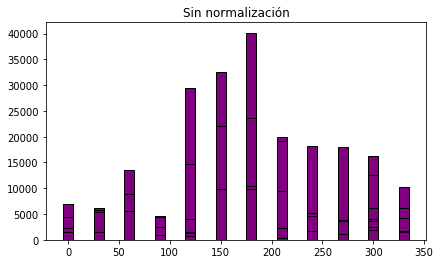

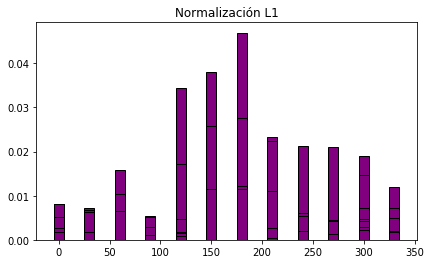

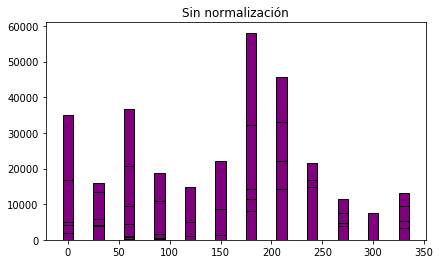

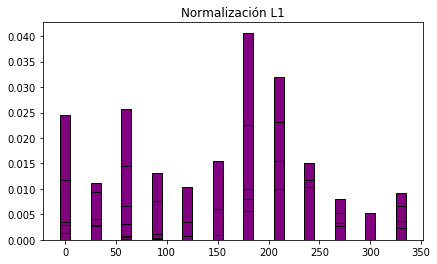

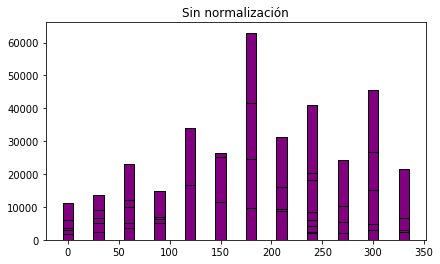

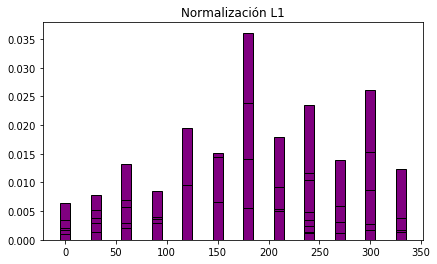

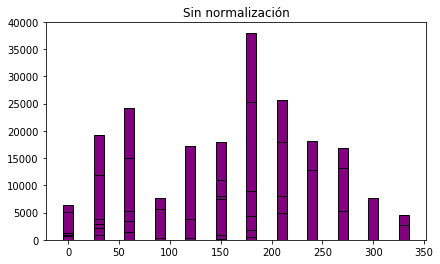

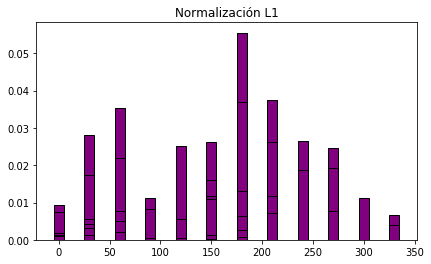

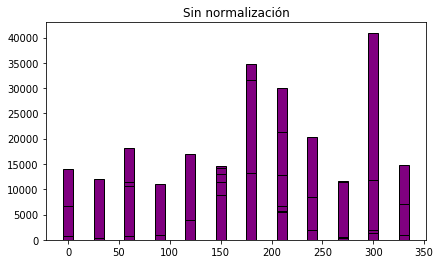

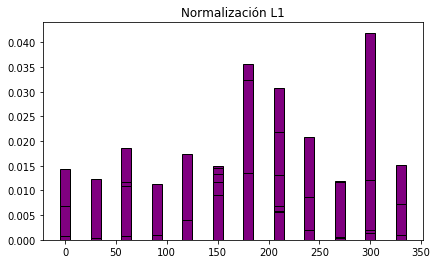

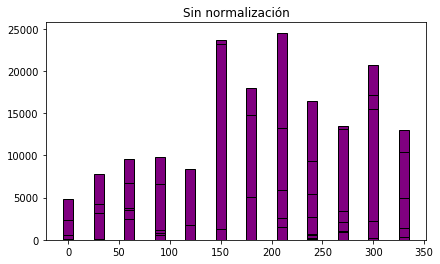

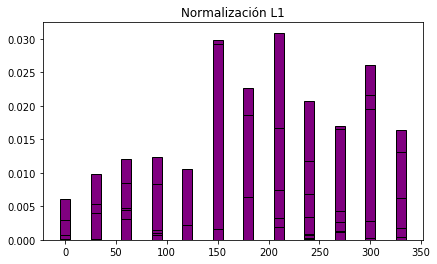

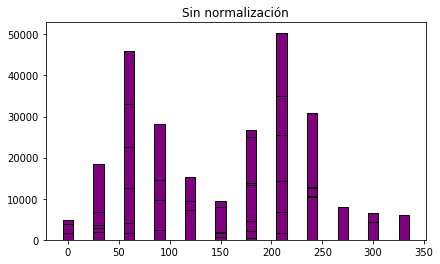

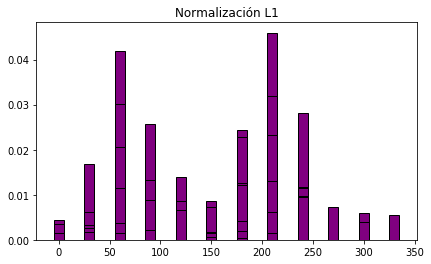

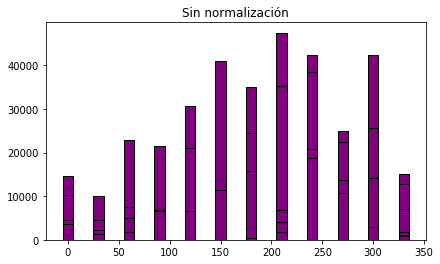

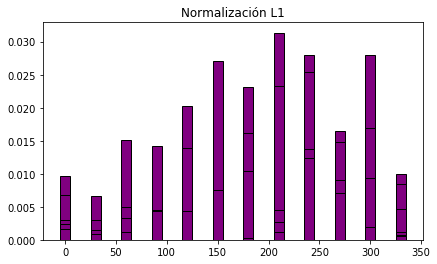

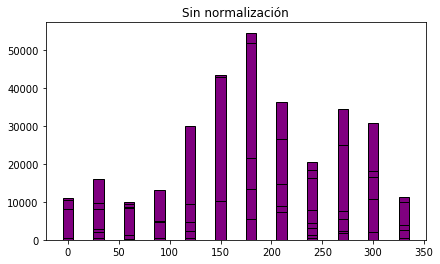

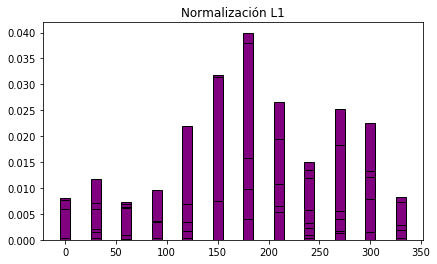

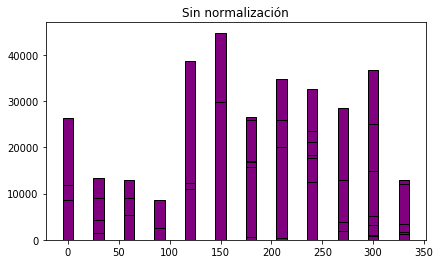

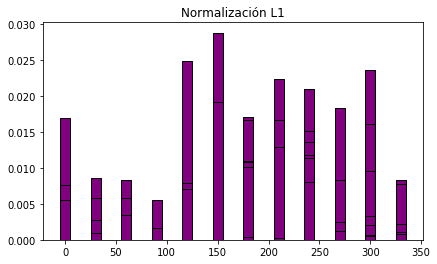

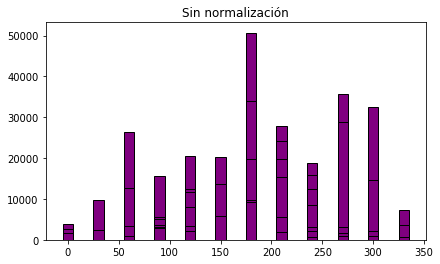

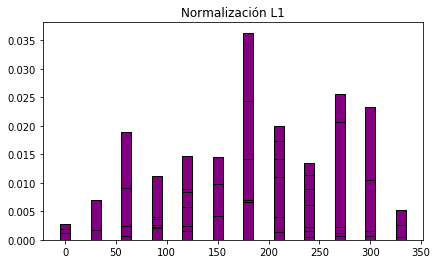

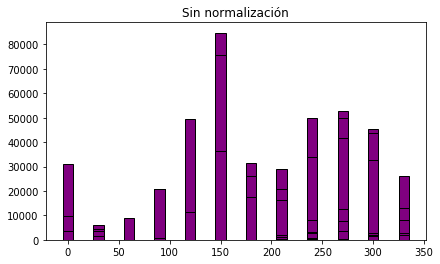

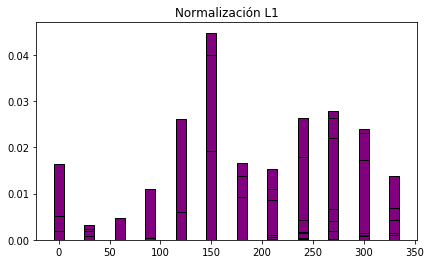

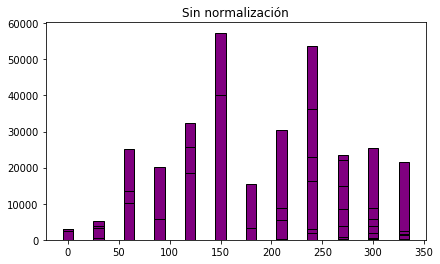

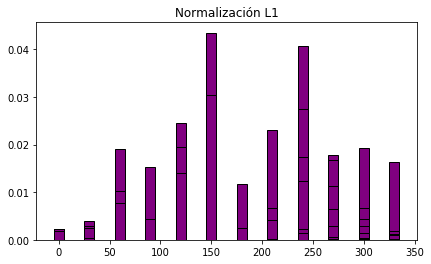

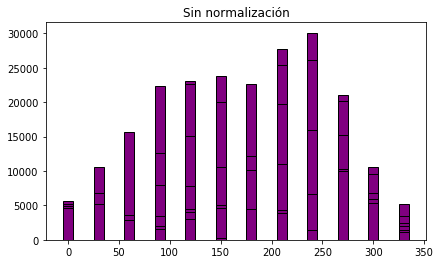

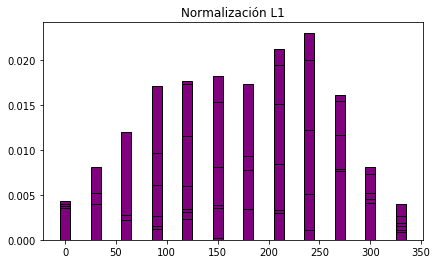

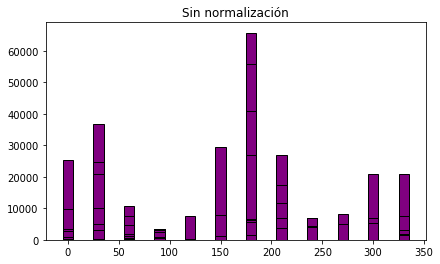

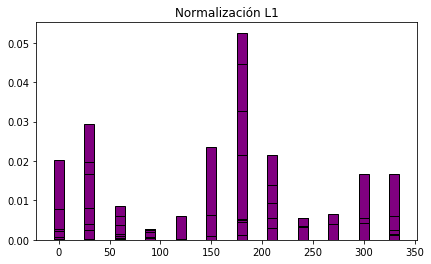

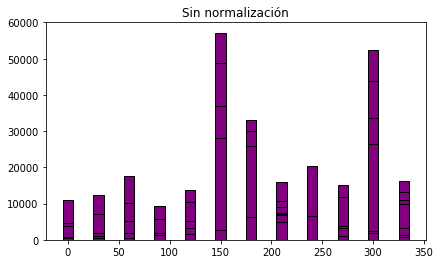

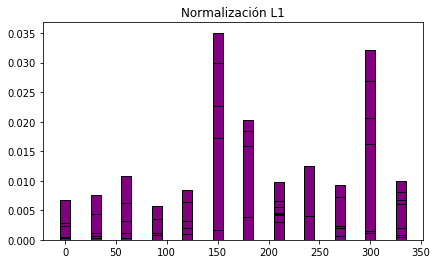

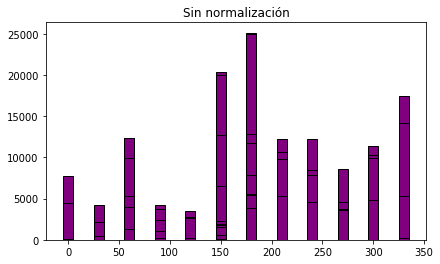

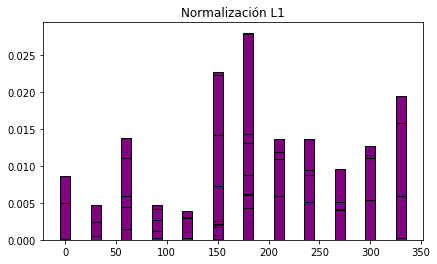

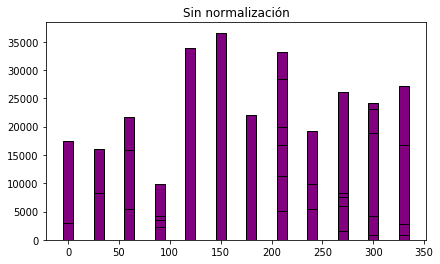

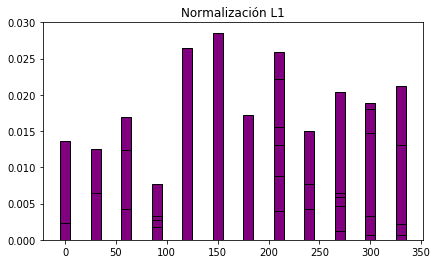

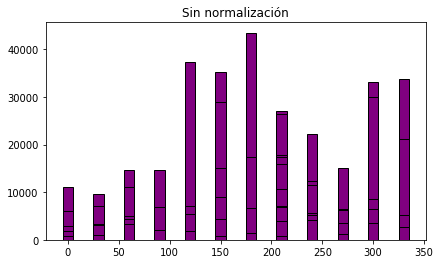

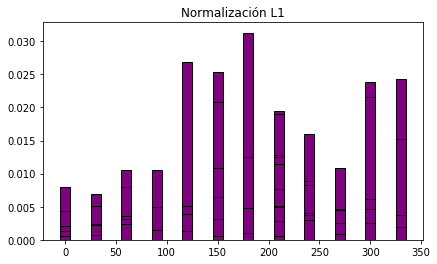

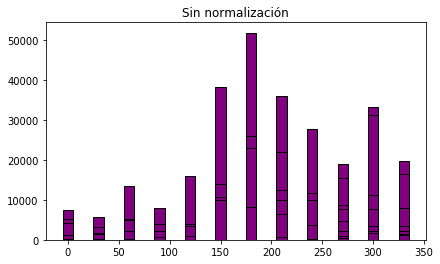

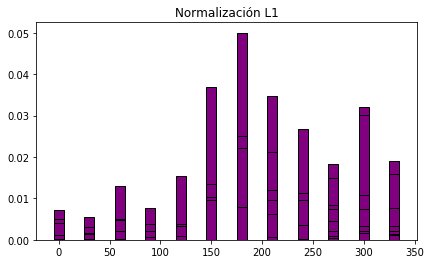

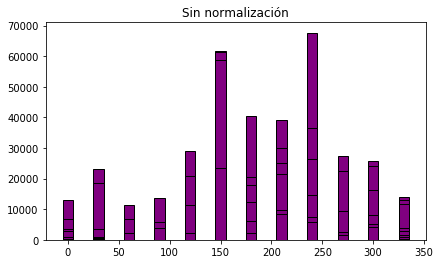

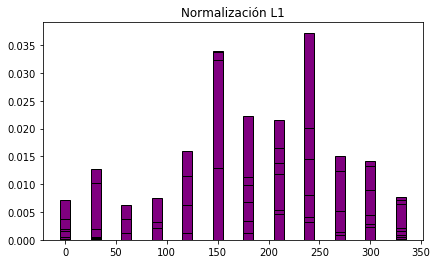

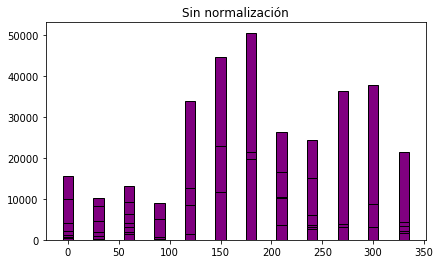

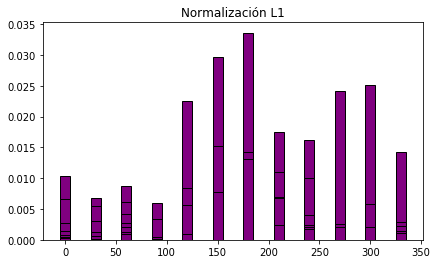

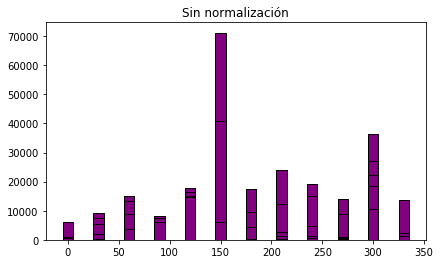

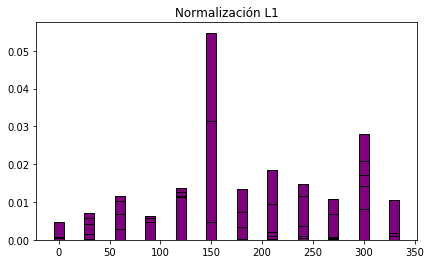

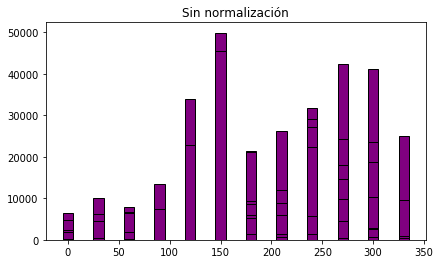

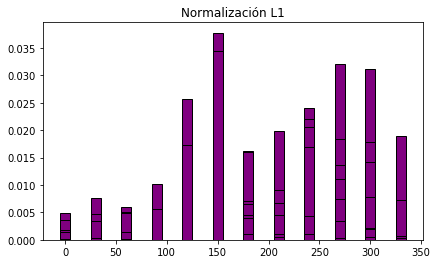

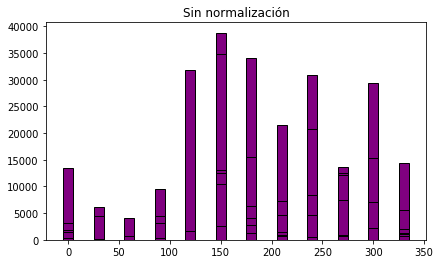

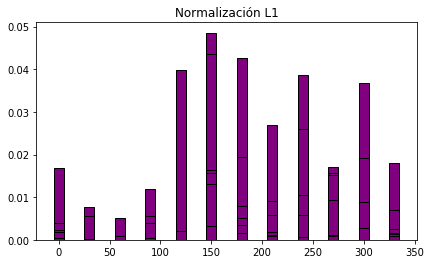

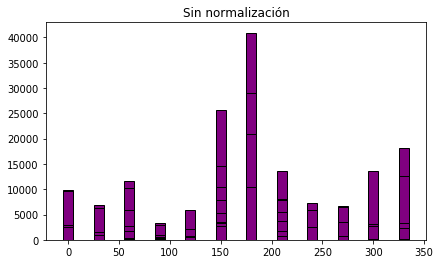

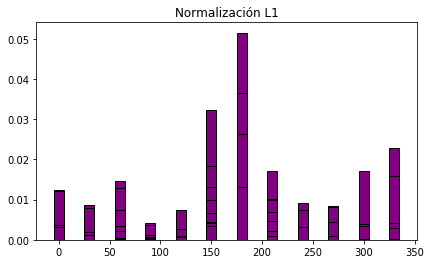

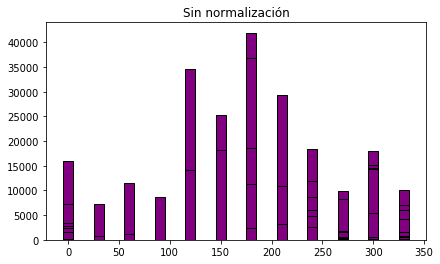

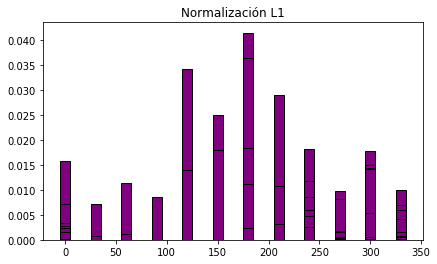

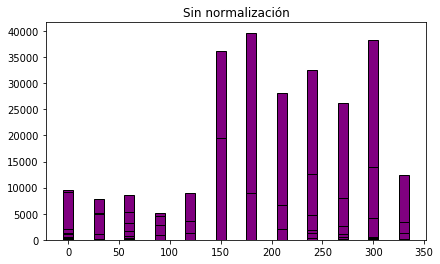

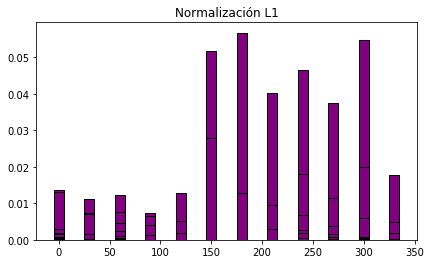

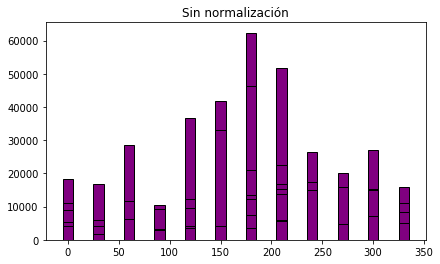

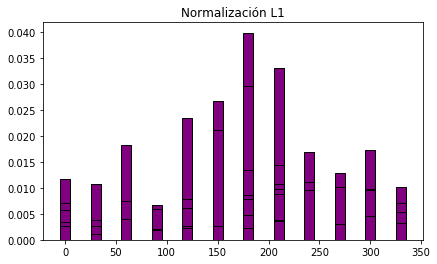

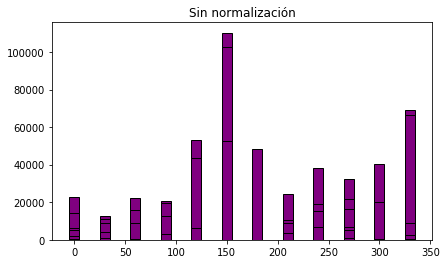

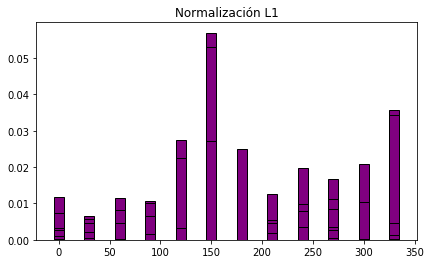

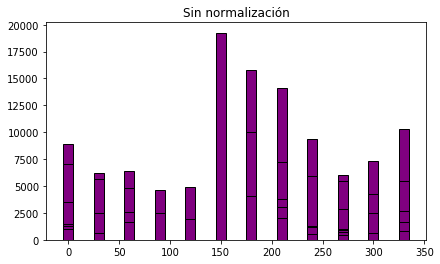

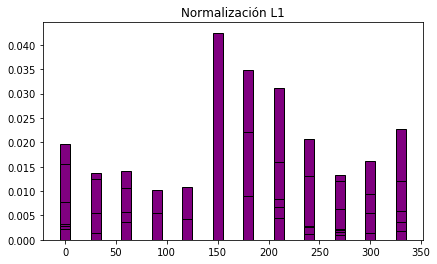

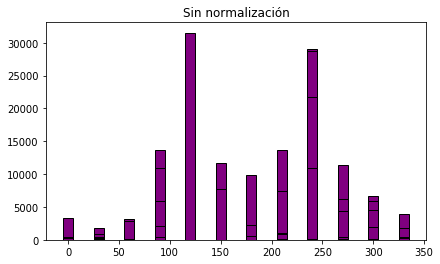

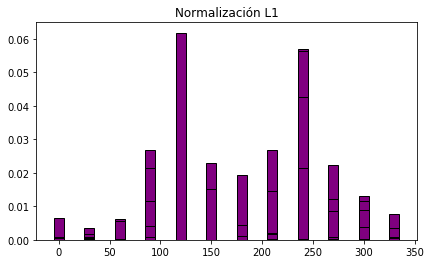

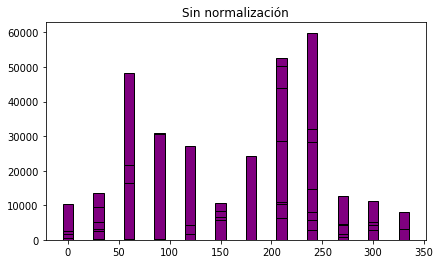

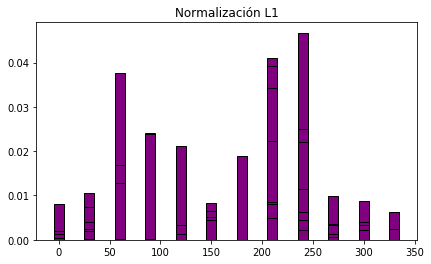

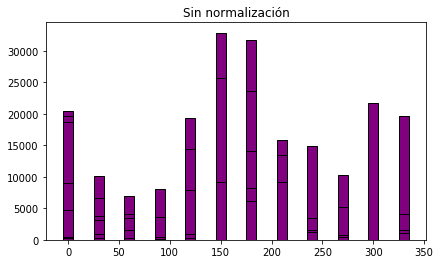

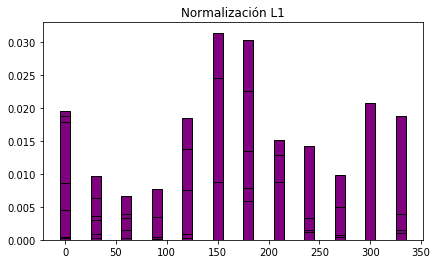

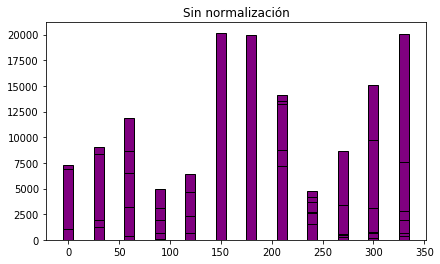

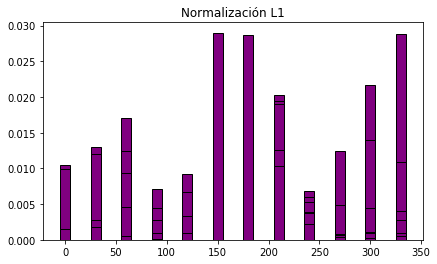

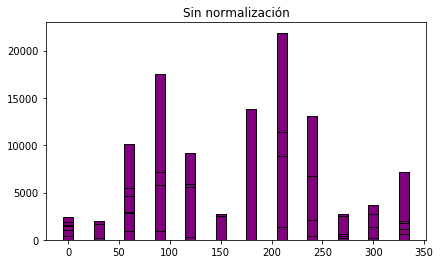

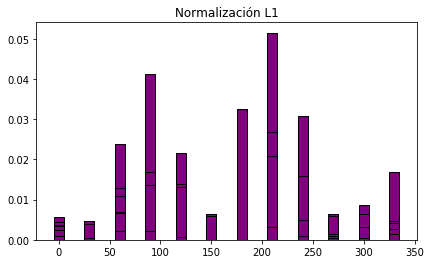

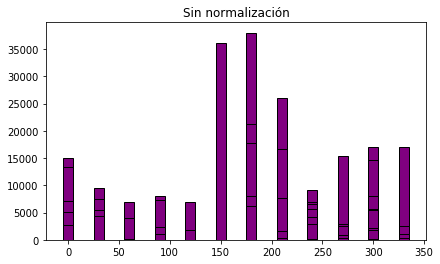

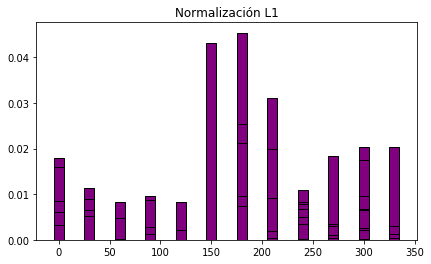

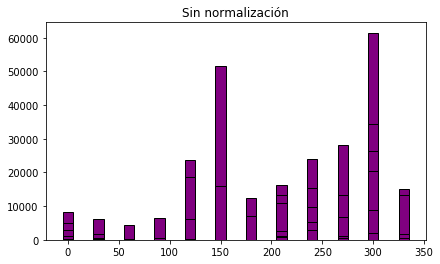

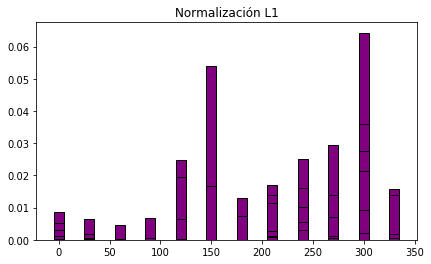

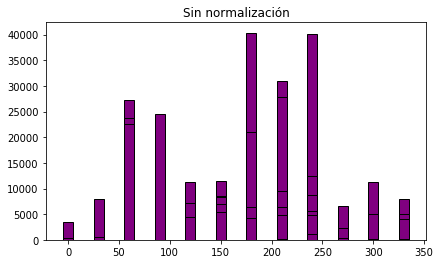

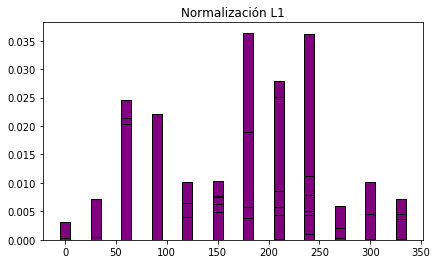

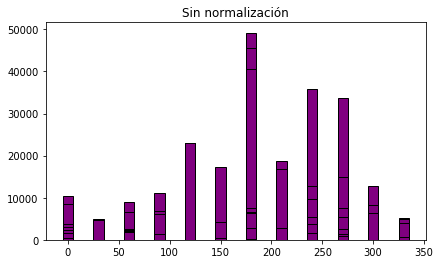

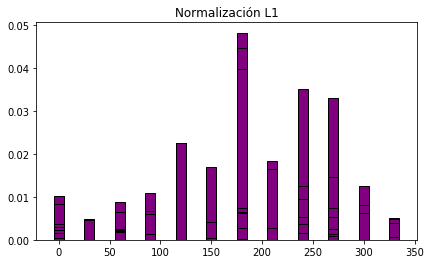

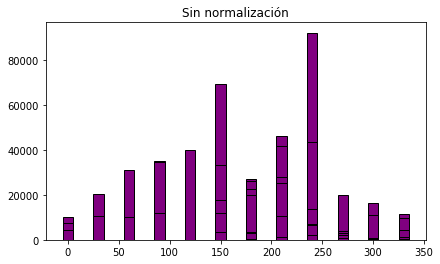

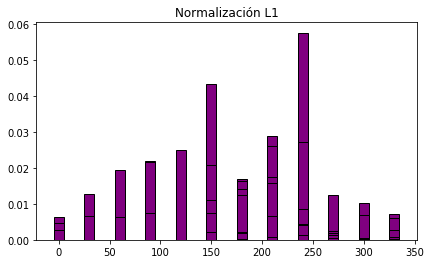

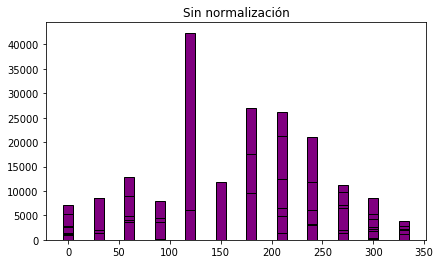

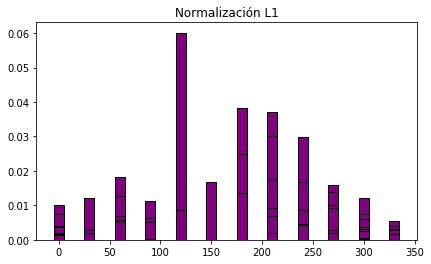

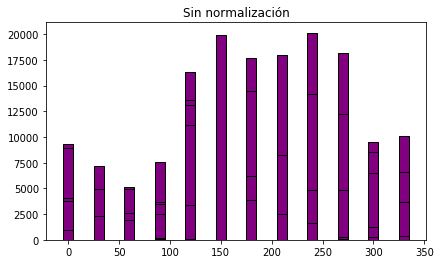

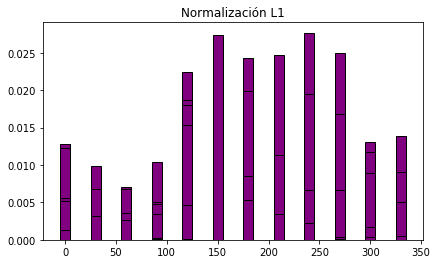

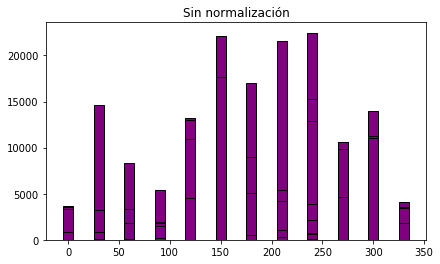

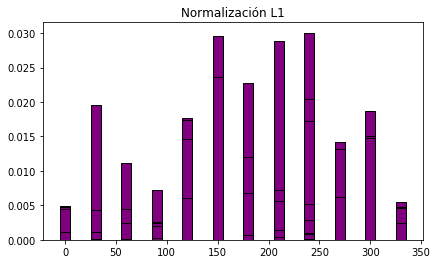

In [13]:
for i in pri_pat:
    print(i)
    hist_mag(i[:10], i[11], 'array_descriptor_final.txt')

for i in sec_pat:
    print(i)
    hist_mag(i[:11], i[12], 'array_descriptor_final.txt')

for i in ter_pat:
    print(i)
    hist_mag(i[:9], i[10], 'array_descriptor_final.txt')
    
for i in cua_pat:
    print(i)
    hist_mag(i[:7], i[8], 'array_descriptor_final.txt')

## PARA UNA IMAGEN

In [43]:
def desc(imagen, i):
    his_ni = []
    
    a = plt.imread(imagen)
    img = cv2.cvtColor(a, cv2.COLOR_BGR2YCrCb)
    
    #Retorna la imágen con los canales Cr y Cb
    imgsc = scale_ycrcb(img)[:,:,1:] #Sólo los dos últimos canales
    magI, angI = arrowsimg(imgsc, 90)
    
    #temp = np.ones(mag.shape)            
    p_m = np.mean(magI)
    d_m = np.std(magI)
        
    t = p_m+d_m*1.5
    #x_n, y_n, magnitud, angulo = tao_(mag, ang, t)
    his_sn, bins_n = np.histogram(angI, bins=12, range=[0,360], weights=magI)
    
    
    painting_bisn(his_sn, bins_n, magI, angI)
    plt.title("Sin normalizar")

    
    his_l1 = preprocessing.normalize(his_sn.reshape(1, -1), norm='l1')
    his_l1 = his_l1[0]  
    painting_bisn(his_l1, bins_n, magI, angI)
    plt.title("Normalización L1")
    print(his_l1)
    
    l1s_his = his_sn/np.sqrt(np.sum(his_sn))
    painting_bisn(l1s_his, bins_n, magI, angI)
    plt.title("Normalización L1_SQRT")

[0.01908088 0.04228215 0.05410383 0.09814072 0.17739451 0.08453224
 0.1959578  0.12873489 0.03754372 0.01131691 0.09004171 0.06087063]


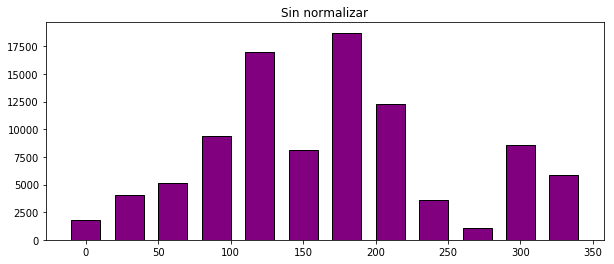

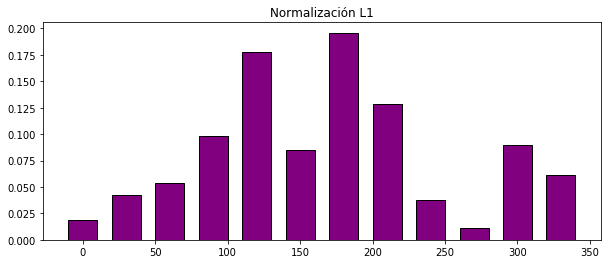

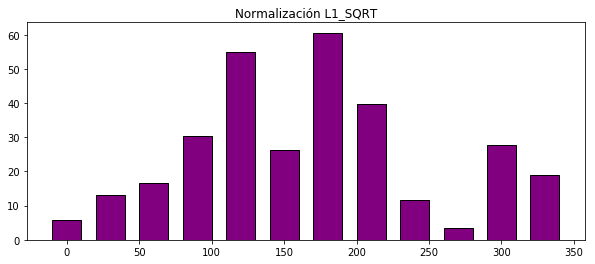

In [44]:
desc('/home/alejandra/HEART/Sunny_tesis/HEART/OFLRV_PPM/SC-HF-I-01/7D/000012.ppm', 12)
#desc('/home/alejandra/HEART/Sunny_tesis/HEART/OFLRV_PPM/SC-HF-I-01/7I/000012.ppm', 12)
